# Comparison between 2$\kappa$ and 2$T$ models

In [29]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
import mpmath as mp
%config InlineBackend.figure_format = 'svg'

In [30]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [327]:
def fk(v):
    r_s = ( 1 + (v-u_s)**2/kappa_s/v_s**2 )**(-kappa_s)
#     r_f = ( 1 + (v-u_f)**2/kappa_f/v_f**2 )**(-kappa_f)
    A_s = n_s/np.sqrt(np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
#     A_f = n_f/np.sqrt(np.pi*kappa_f)/v_f * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    rh = n_h/np.sqrt(np.pi*v_h**2)*np.exp(-(v-u_h)**2/v_h**2)
    return A_s*r_s + rh
#     return A_s*r_s+A_f*r_f


def fm(v):
    rc = n_c/np.sqrt(np.pi*v_c**2)*np.exp(-(v-u_c)**2/v_c**2)
    rh = n_h/np.sqrt(np.pi*v_h**2)*np.exp(-(v-u_h)**2/v_h**2)
    return rc+rh

def PDR_2T(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_c = (wc / k - u_c) /v_c
    zeta_h = (wc / k - u_h) /v_h
    r = 1 + 1 / k**2 / l_c**2 * ( 1 + zeta_c*plasmapy.dispersion.plasma_dispersion_func(zeta_c) ) + 1 / k**2 / l_h**2 * ( 1 + zeta_h*plasmapy.dispersion.plasma_dispersion_func(zeta_h) )
    return [r.real,r.imag]

def PDR_ANAL(k):
    klc = 1+3*k**2*l_c**2+3*l_c**2/l_h**2
    klh = 1+3*k**2*l_h**2
    w_eaw = wp_c*np.sqrt(klc/(1+1/(k*l_h)**2))
    r_eaw = -np.sqrt(np.pi/8) * n_c/n_h * (klc)/(1+k**2*l_h**2)**2 *k*np.sqrt(T_h)
    return w_eaw,r_eaw

def PDR_2K(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
#     r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_f**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1,2*kappa+2,kappa+2,z))
    return fac*hyp

def Set2TParas():
    n_h = n-n_c
    wp_c = np.sqrt( n_c * q**2 )
    wp_h = np.sqrt( n_h * q**2 )
    T_c = 0.5*m*v_c**2
    T_h = 0.5*m*v_h**2
    l_c = np.sqrt(T_c/n_c)
    l_h = np.sqrt(T_h/n_h)
    u_h = a*v_c
    u_c = 0
    return n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h

def Set2KParas():
    n_f = n-n_s
    T = 0.5*m*v_f**2
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    kappa_s = 1.5/(1-v_s**2/v_f**2)
    u_f = a*v_s
    u_s = 0
    return n_f,wp_s,wp_f,l_s,l_f,u_s,u_f,kappa_s,T

def PrintParas():
    paras_table = PrettyTable(['a='+str(a),'n','T','kappa','wp','theta','lambda_D','u'])
    paras_table.add_row(['s',n_s,round(T,4),round(kappa_s,4),round(wp_s,4),round(v_s,4),round(l_s,4),round(u_s,4)])
    paras_table.add_row(['c',n_c,round(T_c,4),'inf',round(wp_c,4),round(v_c,4),round(l_c,4),round(u_c,4)])
    paras_table.add_row(['f',n_f,round(T,4),'inf',round(wp_f,4),round(v_f,4),round(l_f,4),round(u_f,4)])
    paras_table.add_row(['h ',n_h,round(T_h,4),'inf',round(wp_h,4),round(v_h,4),round(l_h,4),round(u_h,4)])
    print(paras_table)

In [442]:
n = 1
q = 1
m = 1

n_c = 0.01
v_c = 0.15
v_h = 1.
n_s = n_c
v_s = v_c
v_f = v_h
a = 10

n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
n_f,wp_s,wp_f,l_s,l_f,u_s,u_f,kappa_s,T=Set2KParas()
PrintParas()

+------+------+--------+--------+-------+-------+----------+-----+
| a=10 |  n   |   T    | kappa  |   wp  | theta | lambda_D |  u  |
+------+------+--------+--------+-------+-------+----------+-----+
|  s   | 0.01 |  0.5   | 1.5345 |  0.1  |  0.15 |  7.0711  |  0  |
|  c   | 0.01 | 0.0112 |  inf   |  0.1  |  0.15 |  1.0607  |  0  |
|  f   | 0.99 |  0.5   |  inf   | 0.995 |  1.0  |  0.7107  | 1.5 |
|  h   | 0.99 |  0.5   |  inf   | 0.995 |  1.0  |  0.7107  | 1.5 |
+------+------+--------+--------+-------+-------+----------+-----+


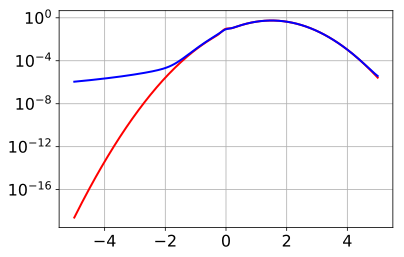

In [443]:
v_list = np.linspace(-5,5,num=200)
plt.plot(v_list,fm(v_list),color='red')
plt.plot(v_list,fk(v_list),color='blue')
# plt.ylim(1e-10,10)
plt.yscale('log')
plt.grid()
plt.show()

In [444]:
k_list = np.linspace(0.1,2.0,num=200)
a_list = np.linspace(0,a,num=11)
w_2T_guess,r_2T_guess = PDR_ANAL(k_list[0])
w_2K_guess = 0.009
r_2K_guess = -0.011
# w_2K_guess = 0.008
# r_2K_guess = -0.007

In [445]:
for a_each in tqdm(a_list,position=0,leave=True):
    u_f = a_each * v_s
    u_h = a_each * v_c
    
    s2K = op.root(lambda w:PDR_2K(w,k_list[0]),[w_2K_guess,r_2K_guess])
    if s2K.success==True:
        w_2K_guess = s2K.x[0]
        r_2K_guess = s2K.x[1]
        
    s2T = op.root(lambda w:PDR_2T(w,k_list[0]),[w_2T_guess,r_2T_guess])
    if s2T.success==True:
        w_2T_guess = s2T.x[0]
        r_2T_guess = s2T.x[1]

100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 118.24it/s]


In [446]:
u_f = a*v_s
u_h = a*v_c

w_2T_list = []
r_2T_list = []
w_2K_list = []
r_2K_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s2K = op.root(lambda w:PDR_2K(w,k_each),[w_2K_guess,r_2K_guess])
    if s2K.success==True:
        w_2K_guess = s2K.x[0]
        r_2K_guess = s2K.x[1]
        w_2K_list.append(s2K.x[0])
        r_2K_list.append(s2K.x[1])
    else:
        w_2K_list.append(np.nan)
        r_2K_list.append(np.nan)
        
    s2T = op.root(lambda w:PDR_2T(w,k_each),[w_2T_guess,r_2T_guess])
    if s2T.success==True:
        w_2T_guess = s2T.x[0]
        r_2T_guess = s2T.x[1]
        w_2T_list.append(s2T.x[0])
        r_2T_list.append(s2T.x[1])
    else:
        w_2T_list.append(np.nan)
        r_2T_list.append(np.nan)

100%|███████████████████████████████████████████████████████| 200/200 [00:01<00:00, 197.43it/s]


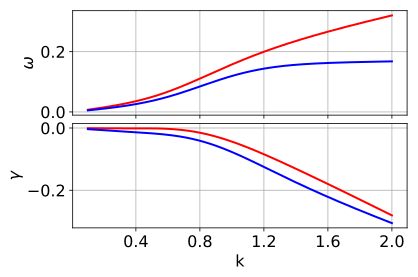

In [447]:
k_ticks = np.linspace(0,k_list[-1],num=6)
fig = plt.figure(figsize=(6,4))

ax1 = plt.subplot(211)
ax1.set_ylabel(r'$\omega$')
plt.xticks(k_ticks,[])
ax1.grid()

ax2 = plt.subplot(212)
plt.xticks(k_ticks)
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

ax1.plot(k_list,w_2T_list,'-',color='red')
ax1.plot(k_list,w_2K_list,'-',color='blue')

ax2.plot(k_list,r_2T_list,color='red')
ax2.plot(k_list,r_2K_list,color='blue')
# ax2.axhline(0,color='black')

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./figs/revised/fig7.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

## unstable regime

## $n_s$ vs $a$

In [455]:
n_c = n_s = 0.01
v_c = v_s = 0.05
v_f = v_h = 1.0
a = 0
n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
n_f,wp_s,wp_f,l_s,l_f,u_s,u_f,kappa_s,T=Set2KParas()

r2T_max_mat = []
r2K_max_mat = []

w_2T_guess,r_2T_guess = PDR_ANAL(k_list[0])
w_2K_guess = 0.008
r_2K_guess = -0.007

n_list = np.linspace(n_s,0.9,num=10)
a_list = np.linspace(0,10,num=10)

w_2T_k0 = r_2T_k0 = 0.0
w_2T_a0 = r_2T_a0 = 0.0
w_2K_k0 = r_2K_k0 = 0.0
w_2K_a0 = r_2K_a0 = 0.0

In [456]:
for n_each in tqdm(n_list,position=0,leave=True):
    n_s = n_each
    n_c = n_each
    r2T_max_list = []
    r2K_max_list = []
    for a_each in a_list:
        a = a_each
        n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
        n_f,wp_s,wp_f,l_s,l_f,u_s,u_f,kappa_s,T=Set2KParas()
        r2T_list=np.array([])
        r2K_list=np.array([])
        for k_each in k_list:
            s2K = op.root(lambda w:PDR_2K(w,k_each),[w_2K_guess,r_2K_guess])
            if s2K.success==True:
                w_2K_guess = s2K.x[0]
                r_2K_guess = s2K.x[1]
                r2K_list = np.append(r2K_list,s2K.x[1])

            s2T = op.root(lambda w:PDR_2T(w,k_each),[w_2T_guess,r_2T_guess])
            if s2T.success==True:
                w_2T_guess = s2T.x[0]
                r_2T_guess = s2T.x[1]
                r2T_list = np.append(r2T_list,s2T.x[1])
                
            if k_each == k_list[0]:
                w_2T_k0 = w_2T_guess
                r_2T_k0 = r_2T_guess
                w_2K_k0 = w_2K_guess
                r_2K_k0 = r_2K_guess
                if a_each == a_list[0]:
                    w_2T_a0 = w_2T_k0
                    r_2T_a0 = r_2T_k0
                    w_2K_a0 = w_2K_k0
                    r_2K_a0 = r_2K_k0
        r2T_max_list.append(np.amax(r2T_list))
        r2K_max_list.append(np.amax(r2K_list))
        w_2T_guess = w_2T_k0
        r_2T_guess = r_2T_k0
        w_2K_guess = w_2K_k0
        r_2K_guess = r_2K_k0
    r2T_max_mat.append(r2T_max_list)
    r2K_max_mat.append(r2K_max_list)
    w_2T_guess = w_2T_a0
    r_2T_guess = r_2T_a0
    w_2K_guess = w_2K_a0
    r_2K_guess = r_2K_a0

100%|██████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.92s/it]


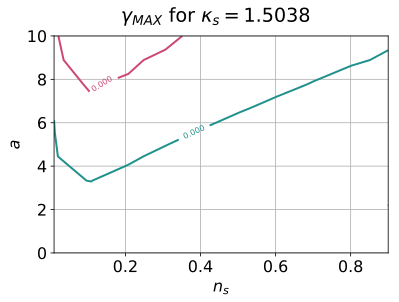

In [457]:
a_grid,n_s_grid=np.meshgrid(a_list,n_list)
c = plt.contour(n_s_grid,a_grid,r2T_max_mat,levels=[-1,0,1])
d = plt.contour(n_s_grid,a_grid,r2K_max_mat,levels=[-1,0,1],cmap='plasma')
plt.clabel(c,inline=True,fontsize=8)
plt.clabel(d,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $\kappa_s=$'+str(round(kappa_s,4)))
plt.xlabel('$n_s$')
plt.ylabel('$a$')
plt.grid()
plt.show()

## $n_s$ vs $\theta_s$

In [464]:
n_c = n_s = 0.01
v_c = v_s = 0.05
v_f = v_h = 1.0
a = 10
n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
n_f,wp_s,wp_f,l_s,l_f,u_s,u_f,kappa_s,T=Set2KParas()

r2T_max_mat = []
r2K_max_mat = []

w_2T_guess,r_2T_guess = PDR_ANAL(k_list[0])
w_2K_guess = 0.008
r_2K_guess = -0.007

n_list = np.linspace(n_s,0.9,num=10)
v_c_list = np.linspace(0.05,0.15,num=3)

w_2T_k0 = r_2T_k0 = 0.0
w_2T_a0 = r_2T_a0 = 0.0
w_2K_k0 = r_2K_k0 = 0.0
w_2K_a0 = r_2K_a0 = 0.0

In [465]:
for n_each in tqdm(n_list,position=0,leave=True):
    n_s = n_each
    n_c = n_each
    r2T_max_list = []
    r2K_max_list = []
    for v_c_each in v_c_list:
        v_s = v_c_each
        v_c = v_c_each
        n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
        n_f,wp_s,wp_f,l_s,l_f,u_s,u_f,kappa_s,T=Set2KParas()
        r2T_list=np.array([])
        r2K_list=np.array([])
        for k_each in k_list:
            s2K = op.root(lambda w:PDR_2K(w,k_each),[w_2K_guess,r_2K_guess])
            if s2K.success==True:
                w_2K_guess = s2K.x[0]
                r_2K_guess = s2K.x[1]
                r2K_list = np.append(r2K_list,s2K.x[1])

            s2T = op.root(lambda w:PDR_2T(w,k_each),[w_2T_guess,r_2T_guess])
            if s2T.success==True:
                w_2T_guess = s2T.x[0]
                r_2T_guess = s2T.x[1]
                r2T_list = np.append(r2T_list,s2T.x[1])
                
            if k_each == k_list[0]:
                w_2T_k0 = w_2T_guess
                r_2T_k0 = r_2T_guess
                w_2K_k0 = w_2K_guess
                r_2K_k0 = r_2K_guess
                if a_each == a_list[0]:
                    w_2T_a0 = w_2T_k0
                    r_2T_a0 = r_2T_k0
                    w_2K_a0 = w_2K_k0
                    r_2K_a0 = r_2K_k0
        r2T_max_list.append(np.amax(r2T_list))
        r2K_max_list.append(np.amax(r2K_list))
        w_2T_guess = w_2T_k0
        r_2T_guess = r_2T_k0
        w_2K_guess = w_2K_k0
        r_2K_guess = r_2K_k0
    r2T_max_mat.append(r2T_max_list)
    r2K_max_mat.append(r2K_max_list)
    w_2T_guess = w_2T_a0
    r_2T_guess = r_2T_a0
    w_2K_guess = w_2K_a0
    r_2K_guess = r_2K_a0

 10%|█████▉                                                     | 1/10 [00:07<01:07,  7.50s/it]


ValueError: zero-size array to reduction operation maximum which has no identity

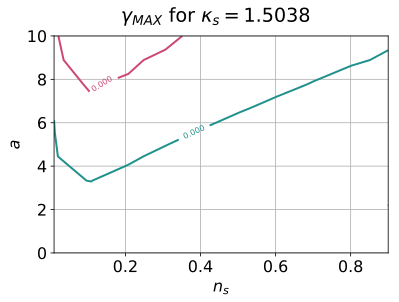

In [460]:
a_grid,n_s_grid=np.meshgrid(a_list,n_list)
c = plt.contour(n_s_grid,a_grid,r2T_max_mat,levels=[-1,0,1])
d = plt.contour(n_s_grid,a_grid,r2K_max_mat,levels=[-1,0,1],cmap='plasma')
plt.clabel(c,inline=True,fontsize=8)
plt.clabel(d,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $\kappa_s=$'+str(round(kappa_s,4)))
plt.xlabel('$n_s$')
plt.ylabel('$a$')
plt.grid()
plt.show()